In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from util import load_dataset, create_learning_curve
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
X_train, y_train = load_dataset("data/bag-of-words-binary/train_bow_large_no_svd.csv", 100000)

Loaded X with shape (100000, 3808), y with shape (100000,).


In [4]:
X_val, y_val = load_dataset("data/bag-of-words-binary/dev_bow_large_no_svd.csv", 5000)

Loaded X with shape (5000, 3808), y with shape (5000,).


## Linear SVMs
Create learning curve with linear SVMs, testing on different training set sizes from 0 to 100,000.

In [5]:
svm_model_params = {
    "loss":"hinge",
    "max_iter": 5000
}
svm_lc_params = [SGDClassifier, svm_model_params, 
             X_train, y_train, X_val, y_val, 
             [1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000]]

In [6]:
svm_lc = create_learning_curve(*svm_lc_params)

Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...


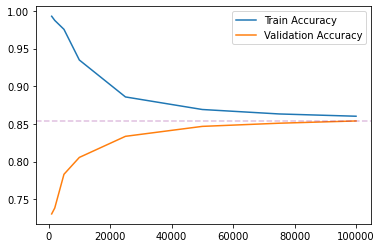

In [8]:
plt.plot(svm_lc['n'], svm_lc['train'], label="Train Accuracy");
plt.plot(svm_lc['n'], svm_lc['val'], label="Validation Accuracy");
plt.axhline(y=svm_lc['val'][-1], xmin=0, xmax=1, linestyle="--", alpha=0.25, color="purple");
plt.legend();

In [9]:
pickle.dump(svm_lc, open("BIG-BAG-SVM-RESULTS.pickle", "wb+"))

The learning curve suggests that more data would not help very much here; the best we can do with this model is approximately 86% validation accuracy.

## Logistic Regression
Again, we train a logistic regression model on different-sized datasets and plot the learning curve.

In [10]:
model_params = {
    "solver":"sag"
}
lc_params = [LogisticRegression, model_params, 
             X_train, y_train, X_val, y_val, 
             [1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000]]

In [11]:
lc = create_learning_curve(*lc_params)

Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...


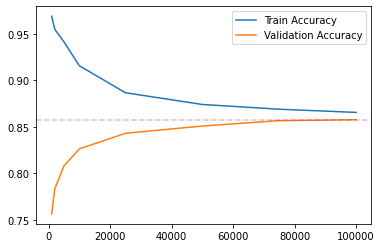

In [13]:
plt.plot(lc['n'], lc['train'], label="Train Accuracy");
plt.plot(lc['n'], lc['val'], label="Validation Accuracy");
plt.axhline(y=lc['val'][-1], xmin=0, xmax=1, linestyle="--", alpha=0.25, color="purple");
plt.legend();

More data seems like it would be of limited help, the training accuracy seems to be converging, so with more training data we could probably get up to around 87%.

In [15]:
pickle.dump(lc, open("BIG-BAG-LOGREG-RESULTS.pickle", "wb+"))

## Kernelized SVMs
We fit an approximate kernel function to the (small) BERT training dataset, and use this to extract new features to fit an SVM. We create a learning curve for each setting of hyperparameters, which include the number of features, and the radius gamma.

In [16]:
kernel_lcs = []
for gamma in [n / 768 for n in [0.01, 0.1, 1.0, 10, 100]]:
    for n_components in [500, 1000]:
        print(f"Kernel approximation using gamma = {gamma}, n_components = {n_components}")
        feature_map_nystroem = Nystroem(gamma=gamma, random_state=229, n_components=n_components)
        X_train_transformed = feature_map_nystroem.fit_transform(X_train)
        X_val_transformed = feature_map_nystroem.transform(X_val)
        kernel_svm_model_params = {
            "loss":"hinge",
            "max_iter": 5000
        }
        kernel_svm_lc_params = [SGDClassifier, svm_model_params, 
                                X_train_transformed, y_train, X_val_transformed, y_val, 
                     [1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000]]
        kernel_svm_lc = create_learning_curve(*kernel_svm_lc_params)
        kernel_svm_lc["gamma"] = gamma
        kernel_svm_lc["n_components"] = n_components
        kernel_lcs.append(kernel_svm_lc)

Kernel approximation using gamma = 1.3020833333333334e-05, n_components = 500
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using gamma = 1.3020833333333334e-05, n_components = 1000
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using gamma = 0.00013020833333333333, n_components = 500
Training model wi

In [20]:
for curr_lc in kernel_lcs:
    plt.plot(curr_lc['n'], curr_lc['train'], label="Train Accuracy");
    plt.plot(curr_lc['n'], curr_lc['val'], label="Validation Accuracy");
    plt.axhline(y=curr_lc['val'][-1], xmin=0, xmax=1, linestyle="--", alpha=0.25, color="purple");
    plt.legend();
    plt.savefig(f"big-bag-kernel-{np.round(curr_lc['gamma'], 5)}-{curr_lc['n_components']}.png")
    plt.close()

After looking at all of these plots, none suggested that the RBF kernel was particularly helpful, or showed a high training accuracy but lower validation accuracy that might be bridged with more data. As such, I decided to move on from this approach.

In [18]:
pickle.dump(kernel_lcs, open("BIG-BAG-KERNEL-RESULTS.pickle", "wb+"))

## Gradient-Boosted Trees
For the final model, I tested gradient boosted trees, creating a learning curve for each setting of the hyperparameters.

In [19]:
hgb_lcs = []
for lr in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
    for l2 in [0, 0.001, 0.01, 0.1]:
        print(f"Kernel approximation using lr = {lr}, regularization = {l2}")
        hgb_model_params = {
            "max_iter": 100,
            "l2_regularization": l2,
            "learning_rate": lr,
            "scoring":"loss",
            "early_stopping":True,
            "validation_fraction": None
        }
        hgb_lc_params = [HGBClassifier, hgb_model_params, 
                    X_train, y_train, X_val, y_val, 
                    [1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000]]
        hgb_lc = create_learning_curve(*hgb_lc_params)
        hgb_lc["lr"] = lr
        hgb_lc["l2"] = l2
        hgb_lcs.append(hgb_lc)

Kernel approximation using lr = 0.001, regularization = 0
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using lr = 0.001, regularization = 0.001
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using lr = 0.001, regularization = 0.01
Training model with 1000 training examples...
Training model with 2000 

Kernel approximation using lr = 0.1, regularization = 0.1
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using lr = 0.3, regularization = 0
Training model with 1000 training examples...
Training model with 2000 training examples...
Training model with 5000 training examples...
Training model with 10000 training examples...
Training model with 25000 training examples...
Training model with 50000 training examples...
Training model with 75000 training examples...
Training model with 100000 training examples...
Kernel approximation using lr = 0.3, regularization = 0.001
Training model with 1000 training examples...
Training model with 2000 trainin

In [21]:
for hgb_lc in hgb_lcs:
    plt.plot(hgb_lc['n'], hgb_lc['train'], label="Train Accuracy");
    plt.plot(hgb_lc['n'], hgb_lc['val'], label="Validation Accuracy");
    plt.axhline(y=hgb_lc['val'][-1], xmin=0, xmax=1, linestyle="--", alpha=0.25, color="purple");
    plt.legend();
    plt.savefig(f"big-bag-hgb-lr{hgb_lc['lr']}-l2{hgb_lc['l2']}.png")
    plt.close()

In [22]:
pickle.dump(hgb_lc, open("BIG-BAG-HGB-SMALL-RESULTS.pickle", "wb+"))

In [23]:
hgblc_dict = {(h["lr"], h["l2"]):h for h in hgb_lcs}

In [24]:
good_lc = hgblc_dict[(1, 0.01)]

Some of these learning curves suggest that more data (or other methods to reduce variance) could yield a higher accuracy that the best models so far. For example, the following learning curve with learning rate 1 and L2 regularization parameter 0.01.

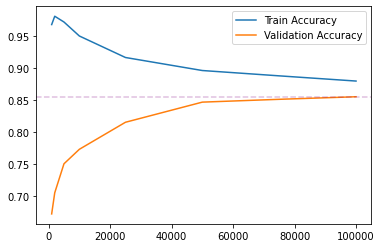

In [25]:
plt.plot(good_lc['n'], good_lc['train'], label="Train Accuracy");
plt.plot(good_lc['n'], good_lc['val'], label="Validation Accuracy");
plt.axhline(y=good_lc['val'][-1], xmin=0, xmax=1, linestyle="--", alpha=0.25, color="purple");
plt.legend();

## Gradient-Boosted Trees with More Data
We investigate using more training data. We stick with 5000 examples for validation. We also increase the maximum number of trees permitted so that the model can be more expressive, relying on more training data to reduce variance.

In [27]:
X_train_full, y_train_full = load_dataset(
    "data/bag-of-words-binary/train_bow_large_no_svd.csv", 2500000
)

Loaded X with shape (2500000, 3808), y with shape (2500000,).


In [28]:
# Learning rate: 1
# Regularization: 0.01
big_hgb_model_params = {
    "max_iter": 150,
    "l2_regularization": 0.6,
    "learning_rate": 0.6,
    "scoring":"loss",
    "early_stopping":True,
    "validation_fraction": None
}
model = HGBClassifier(**big_hgb_model_params)

In [29]:
model.fit(X_train_full, y_train_full.astype('int'))

HistGradientBoostingClassifier(early_stopping=True, l2_regularization=0.6,
                               learning_rate=0.6, max_iter=150,
                               validation_fraction=None)

In [30]:
model.score(X_train_full, y_train_full.astype('int'))

0.8635372

In [31]:
model.score(X_val, y_val)

0.8704

In [32]:
# Learning rate: 0.9
# Regularization: 0.5
big_hgb_model_params_2 = {
    "max_iter": 200,
    "l2_regularization": 0.5,
    "learning_rate": 0.9,
    "scoring":"loss",
    "early_stopping": True,
    "validation_fraction": None
}
model2 = HGBClassifier(**big_hgb_model_params)

In [33]:
model2.fit(X_train_full, y_train_full.astype('int'))

HistGradientBoostingClassifier(early_stopping=True, l2_regularization=0.6,
                               learning_rate=0.6, max_iter=150,
                               validation_fraction=None)

In [34]:
model2.score(X_train_full, y_train_full.astype('int'))

0.8635372

In [35]:
model2.score(X_val, y_val)

0.8704

In [36]:
pickle.dump(model2, open("BIG-BAG-BEST-HGB-BIG.pickle", "wb+"))

## Ensemble
Create a voting ensemble that leverages the best SVM, logistic regression, and decision tree.

In [37]:
svm_data = pickle.load(open("BIG-BAG-SVM-RESULTS.pickle", "rb"))
best_svm = svm_data["model"][-1]

In [38]:
logreg_data = pickle.load(open("BIG-BAG-LOGREG-RESULTS.pickle", "rb"))
best_logreg = logreg_data["model"][-1]

In [39]:
best_hgb = pickle.load(open("BIG-BAG-BEST-HGB-BIG.pickle", "rb"))

In [40]:
from mlxtend.classifier import EnsembleVoteClassifier
import copy
ensemble = EnsembleVoteClassifier(
    clfs=[best_svm, best_logreg, best_hgb], 
    weights=[1, 1, 1], 
    fit_base_estimators=False)

In [41]:
ensemble.fit(X_train, y_train)

/Users/ben/.pyenv/versions/3.8.5/envs/data-analysis/lib/python3.8/site-packages/mlxtend/classifier/ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


EnsembleVoteClassifier(clfs=[SGDClassifier(max_iter=5000),
                             LogisticRegression(solver='sag'),
                             HistGradientBoostingClassifier(early_stopping=True,
                                                            l2_regularization=0.6,
                                                            learning_rate=0.6,
                                                            max_iter=150,
                                                            validation_fraction=None)],
                       fit_base_estimators=False, use_clones=False,
                       weights=[1, 1, 1])

In [42]:
ensemble.score(X_train, y_train)

0.86628

In [43]:
ensemble.score(X_val, y_val)

0.864

This is no better than the best boosted decision tree.

## Testing Data and Error Analysis
Run the best model from each category on the testing data, and visualize errors.

In [44]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [45]:
X_test, y_test = load_dataset("data/bag-of-words-binary/test_bow_large_no_svd.csv", 5000)

Loaded X with shape (5000, 3808), y with shape (5000,).


#### SVM

In [46]:
svm_preds = best_svm.predict(X_test)

In [47]:
best_svm.score(X_test, y_test)

0.8424

In [48]:
# Row: Ground Truth; Column: Predicted Label
pd.DataFrame(confusion_matrix(y_test, svm_preds))

,0,1
0,2027,449
1,339,2185


#### Logistic Regression

In [49]:
lr_preds = best_logreg.predict(X_test)

In [50]:
best_logreg.score(X_test, y_test)

0.8458

In [51]:
# Row: Ground Truth; Column: Predicted Label
pd.DataFrame(confusion_matrix(y_test, lr_preds))

,0,1
0,2090,386
1,385,2139


#### Decision Tree Ensemble

In [52]:
hgb_preds = best_hgb.predict(X_test)

In [53]:
best_hgb.score(X_test, y_test)

0.866

In [54]:
# Row: Ground Truth; Column: Predicted Label
pd.DataFrame(confusion_matrix(y_test, hgb_preds))

,0,1
0,2148,328
1,342,2182
